# Quora Question Pairs
# Part 2. Deep NLP

[Kaggle competition](https://www.kaggle.com/c/quora-question-pairs)   
Anthony Kulesh  
Spring 2017

![Caption for the picture.](http://resource.mymagic.my/wp-content/uploads/2015/12/quora-e1451290677883.png)

## Description
Where else but Quora can a physicist help a chef with a math problem and get cooking tips in return? Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Currently, Quora uses a Random Forest model to identify duplicate questions. In this competition, Kagglers are challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

## Evaluation
Submissions are evaluated on the log loss between the predicted values and the ground truth.  

$$-log P(y_{true}|~y_{pred}) = -(y_{true} * log(y_{pred}) + (1-y_{true}) * log(1-y_{pred}))$$

## Solutions
1. Abhishek Thakur. [Is That a Duplicate Quora Question?](https://www.linkedin.com/pulse/duplicate-quora-question-abhishek-thakur)  
2. @the1owl. [Matching ¿Que? for Quora - End to End 0.33719 PB](https://www.kaggle.com/the1owl/quora-question-pairs/matching-que-for-quora-end-to-end-0-33719-pb)  
3. @qianqian. [fm benchmark with tfidf around 29](https://github.com/qqgeogor/kaggle_quora_benchmark)

## Useful sources
1. [Discriminative Phrase Embedding for Paraphrase Identification](https://arxiv.org/pdf/1604.00503.pdf) 
2. [LogLoss calibration](https://github.com/numeristical/introspective)  
3. [3 Idiots' Solution & LIBFFM](https://www.kaggle.com/c/criteo-display-ad-challenge/discussion/10555)  
4. [From Word Embeddings To Document Distances](http://jmlr.org/proceedings/papers/v37/kusnerb15.pdf)

---
## Loading data
Required libraries

In [1]:
import time
import warnings
warnings.filterwarnings('ignore')

import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import gensim 
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))

#import ml_insights as mli
import scipy.spatial as sp
from scipy.stats import skew, kurtosis
from scipy.spatial import distance
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

Data

In [2]:
path_to_data = '/home/data/share/quora/'

qtrain = pd.read_csv('questions_train.csv', header=None)
qtest = pd.read_csv('questions_test.csv', header=None).fillna('empty')
all_questions = pd.concat((qtrain, qtest))

qtrain_lem = pd.read_csv('questions_train_lem.csv', header=None)
qtest_lem = pd.read_csv('questions_test_lem.csv', header=None).fillna('empty')
all_questions_lem = pd.concat((qtrain_lem, qtest_lem))

# target
Y_train = pd.read_csv(path_to_data + 'train.csv', usecols=['is_duplicate'])

Features

In [3]:
X_train = pd.read_csv('train_f1.csv')
X_test = pd.read_csv('test_f1.csv')

n_train, n_test = len(X_train), len(X_test)

Sample submission

In [4]:
sample = pd.read_csv(path_to_data + 'sample_submission.csv')
sample.head()

,test_id,is_duplicate
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


## Pickling data

In [5]:
def pickling_data(name, data):
    out = open(name + '.pkl', 'wb')
    pickle.dump(data, out)
    out.close()
    
def load_data(name):
    pkl_file = open(name + '.pkl', 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

## Word2Vec
### Google-News

In [75]:
path_to_model = '/home/data/word2vec/english/'
model_name = 'GoogleNews-vectors-negative300.bin'

In [76]:
model_news = gensim.models.KeyedVectors.load_word2vec_format(path_to_model + model_name, binary=True)

#### Question vector

In [77]:
voc = set(model_news.index2word)
print("Vocabulary size: %d" % len(voc))

Vocabulary size: 3000000


In [78]:
def makeFeatureVec(words, model, voc, num_features, stop=True):

    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    
    for word in words.split():
        if stop:
            if word in voc: 
                nwords = nwords + 1.
                featureVec = np.add(featureVec,model[word])
        elif (word in voc) and (word not in stops):
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
        

    featureVec = np.divide(featureVec,nwords + 1)
    return featureVec


def getAvgFeatureVecs(questions, model, voc, num_features, stop=True):
    counter = 0.
    questionFeatureVecs = np.zeros((len(questions),num_features),dtype="float32")
    for question in questions:
        questionFeatureVecs[counter] = makeFeatureVec(question, model, \
           voc, num_features, stop)

        counter = counter + 1.
    return questionFeatureVecs

In [79]:
%%time
num_features = 300
trainDataVecs_stop = getAvgFeatureVecs(qtrain[0], model_news, voc, num_features)
trainDataVecs = getAvgFeatureVecs(qtrain[0], model_news, voc, num_features, stop=False)

testDataVecs_stop = getAvgFeatureVecs(qtest[0], model_news, voc, num_features)
testDataVecs = getAvgFeatureVecs(qtest[0], model_news, voc, num_features, stop=False)

CPU times: user 4min 38s, sys: 9.83 s, total: 4min 47s
Wall time: 5min 8s
Compiler : 140 ms


#### Word Mover's Distance

In [80]:
def wmd(q1, q2, model, stop=True):
    q1 = q1.split()
    q2 = q2.split()
    if stop:
        q1 = [w for w in q1 if w not in stops]
        q2 = [w for w in q2 if w not in stops]
    return model.wmdistance(q1, q2)

In [81]:
%time

X_train['wmd'] = [wmd(qtrain[0].loc[i], qtrain[0].loc[n_train + i], model_news) for i in range(n_train)]
X_train['wmd_stop'] = [wmd(qtrain[0].loc[i], qtrain[0].loc[n_train + i], model_news, False) for i in range(n_train)]

X_test['wmd'] = [wmd(qtest[0].loc[i], qtest[0].loc[n_test + i], model_news) for i in range(n_test)]
X_test['wmd_stop'] = [wmd(qtest[0].loc[i], qtest[0].loc[n_test + i], model_news, False) for i in range(n_test)]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs


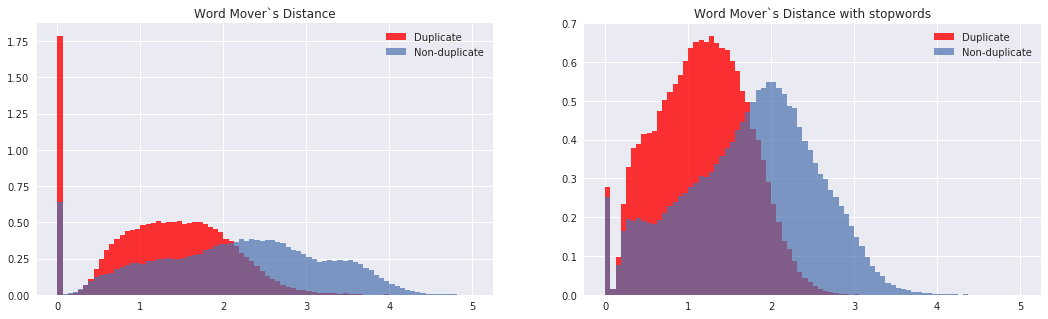

In [82]:
mask = Y_train['is_duplicate'] == 1

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("Word Mover`s Distance")
plt.hist(X_train['wmd'][mask], bins=80, range=[0,5], alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['wmd'][~mask], bins=80, alpha=0.7, range=[0,5], normed=True, label='Non-duplicate');
plt.legend()

plt.subplot(1,2,2)
plt.title("Word Mover`s Distance with stopwords")
plt.hist(X_train['wmd_stop'][mask], bins=80, alpha=0.8, range=[0,5], color='r', normed=True, label='Duplicate');
plt.hist(X_train['wmd_stop'][~mask], bins=80, alpha=0.7, range=[0,5], normed=True, label='Non-duplicate');
plt.legend()
plt.show()

#### Cosine Similarity

In [83]:
def cos_sim(q1_mtx, q2_mtx, n=n_train):
    
    labels = np.append(np.arange(0, n, 30000), n)
    sim = np.array([])

    for i in range(len(labels)-1):
        start = labels[i]
        end = labels[i+1]
        chunk = cosine_similarity(q1_mtx[start:end], q2_mtx[start:end], dense_output=False)
        sim = np.append(sim, chunk.diagonal()) 
    return sim

In [84]:
%%time

X_train['w2v_news_cos'] = cos_sim(trainDataVecs[:n_train], trainDataVecs[n_train:], n=n_train)
X_test['w2v_news_cos'] = cos_sim(testDataVecs[:n_test], testDataVecs[n_test:], n=n_test)

X_train['w2v_news_stop_cos'] = cos_sim(trainDataVecs_stop[:n_train], trainDataVecs_stop[n_train:], n=n_train)
X_test['w2v_news_stop_cos'] = cos_sim(testDataVecs_stop[:n_test], testDataVecs_stop[n_test:], n=n_test)

CPU times: user 20min 48s, sys: 3min 25s, total: 24min 14s
Wall time: 6min 21s


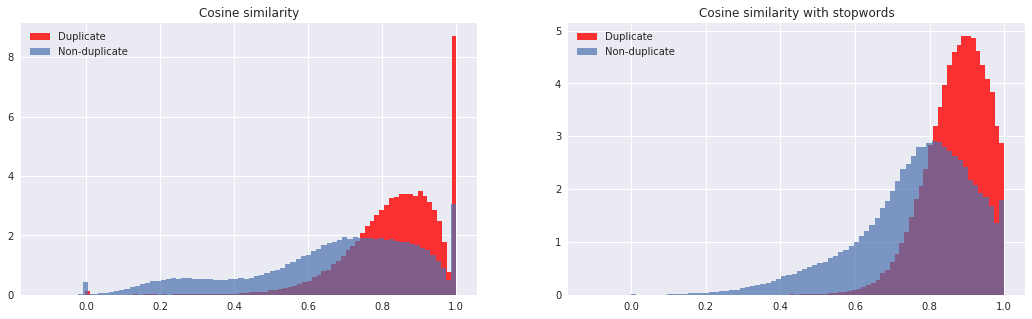

In [85]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("Cosine similarity")
plt.hist(X_train['w2v_news_cos'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['w2v_news_cos'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()

plt.subplot(1,2,2)
plt.title("Cosine similarity with stopwords")
plt.hist(X_train['w2v_news_stop_cos'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['w2v_news_stop_cos'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()
plt.show()

**Bray-Curtis distance**

In [86]:
%%time

X_train['braycurtis'] = [distance.braycurtis(trainDataVecs[i], trainDataVecs[i + n_train]) for i in range(n_train)] 
X_test['braycurtis'] = [distance.braycurtis(testDataVecs[i], testDataVecs[i + n_test]) for i in range(n_test)] 

X_train['braycurtis_stop'] = [distance.braycurtis(trainDataVecs_stop[i], trainDataVecs_stop[i + n_train]) for i in range(n_train)] 
X_test['braycurtis_stop'] = [distance.braycurtis(testDataVecs_stop[i], testDataVecs_stop[i + n_test]) for i in range(n_test)] 

CPU times: user 1min 15s, sys: 217 ms, total: 1min 15s
Wall time: 1min 15s


In [87]:
X_train['braycurtis'].fillna(0, inplace=True)
X_test['braycurtis'].fillna(0, inplace=True)
X_train['braycurtis_stop'].fillna(0, inplace=True)
X_test['braycurtis_stop'].fillna(0, inplace=True)

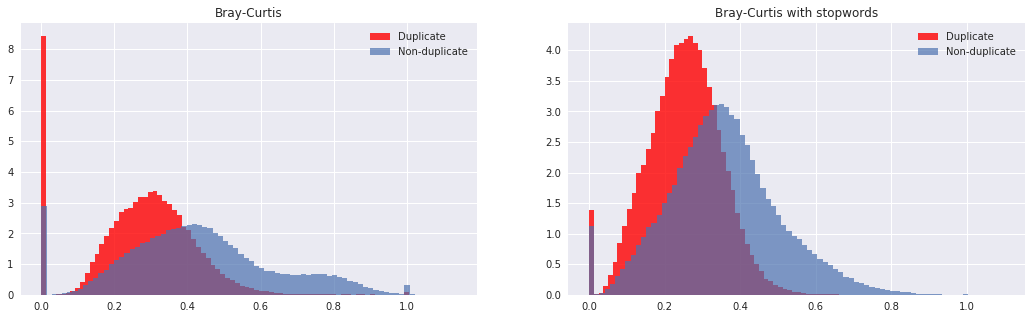

In [88]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("Bray-Curtis")
plt.hist(X_train['braycurtis'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['braycurtis'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()

plt.subplot(1,2,2)
plt.title("Bray-Curtis with stopwords")
plt.hist(X_train['braycurtis_stop'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['braycurtis_stop'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()
plt.show()

**Canberra distance**

In [89]:
%%time

X_train['canberra'] = [distance.canberra(trainDataVecs[i], trainDataVecs[i + n_train]) for i in range(n_train)] 
X_test['canberra'] = [distance.canberra(testDataVecs[i], testDataVecs[i + n_test]) for i in range(n_test)] 

X_train['canberra_stop'] = [distance.canberra(trainDataVecs_stop[i], trainDataVecs_stop[i + n_train]) for i in range(n_train)] 
X_test['canberra_stop'] = [distance.canberra(testDataVecs_stop[i], testDataVecs_stop[i + n_test]) for i in range(n_test)] 

CPU times: user 2min 17s, sys: 406 ms, total: 2min 17s
Wall time: 2min 17s


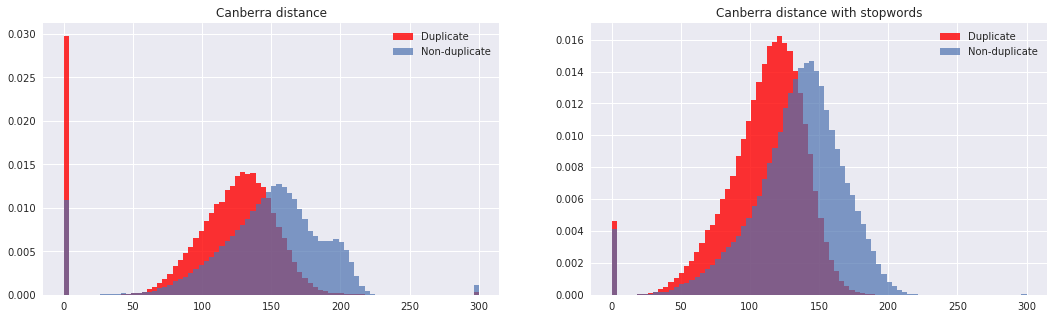

In [90]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("Canberra distance")
plt.hist(X_train['canberra'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['canberra'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()

plt.subplot(1,2,2)
plt.title("Canberra distance with stopwords")
plt.hist(X_train['canberra_stop'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['canberra_stop'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()
plt.show()

**Chebyshev distance**

In [91]:
%%time

X_train['chebyshev'] = [distance.chebyshev(trainDataVecs[i], trainDataVecs[i + n_train]) for i in range(n_train)] 
X_test['chebyshev'] = [distance.chebyshev(testDataVecs[i], testDataVecs[i + n_test]) for i in range(n_test)] 

X_train['chebyshev_stop'] = [distance.chebyshev(trainDataVecs_stop[i], trainDataVecs_stop[i + n_train]) for i in range(n_train)] 
X_test['chebyshev_stop'] = [distance.chebyshev(testDataVecs_stop[i], testDataVecs_stop[i + n_test]) for i in range(n_test)] 

CPU times: user 1min 53s, sys: 144 ms, total: 1min 53s
Wall time: 1min 53s


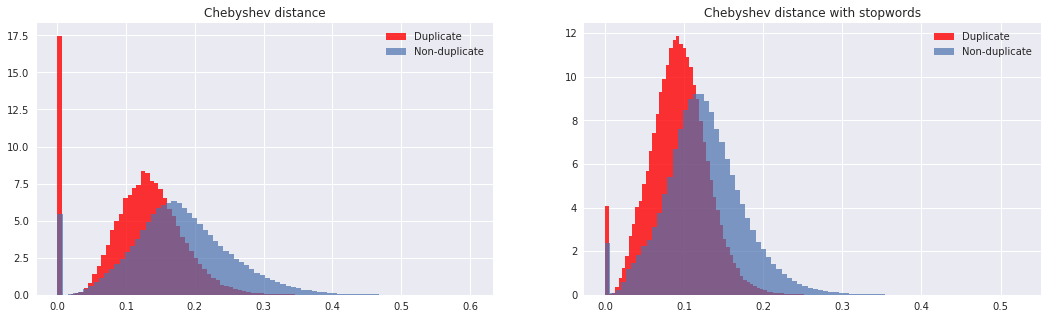

In [92]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("Chebyshev distance")
plt.hist(X_train['chebyshev'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['chebyshev'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()

plt.subplot(1,2,2)
plt.title("Chebyshev distance with stopwords")
plt.hist(X_train['chebyshev_stop'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['chebyshev_stop'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()
plt.show()

**Correlation**

In [93]:
%%time

X_train['correlation'] = [distance.correlation(trainDataVecs[i], trainDataVecs[i + n_train]) for i in range(n_train)] 
X_test['correlation'] = [distance.correlation(testDataVecs[i], testDataVecs[i + n_test]) for i in range(n_test)] 

X_train['correlation_stop'] = [distance.correlation(trainDataVecs_stop[i], trainDataVecs_stop[i + n_train]) for i in range(n_train)] 
X_test['correlation_stop'] = [distance.correlation(testDataVecs_stop[i], testDataVecs_stop[i + n_test]) for i in range(n_test)] 

CPU times: user 4min 8s, sys: 932 ms, total: 4min 9s
Wall time: 4min 8s


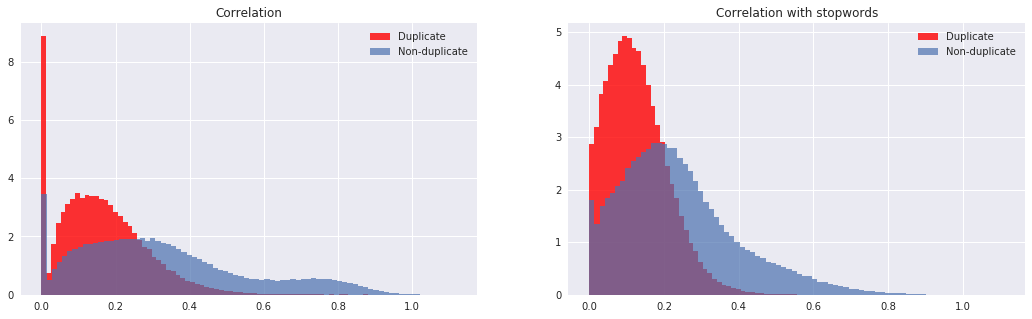

In [94]:
X_train['correlation'].fillna(0, inplace=True)
X_test['correlation'].fillna(0, inplace=True)
X_train['correlation_stop'].fillna(0, inplace=True)
X_test['correlation_stop'].fillna(0, inplace=True)

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("Correlation")
plt.hist(X_train['correlation'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['correlation'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()

plt.subplot(1,2,2)
plt.title("Correlation with stopwords")
plt.hist(X_train['correlation_stop'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['correlation_stop'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()
plt.show()

In [95]:
features = ['wmd', 'wmd_stop', 'w2v_news_cos', 'w2v_news_stop_cos', 'braycurtis',
           'braycurtis_stop', 'canberra', 'canberra_stop', 'chebyshev',
           'chebyshev_stop', 'correlation', 'correlation_stop']

X_train[features].to_csv('train_f2.csv')
X_test[features].to_csv('test_f2.csv')

### fastText

In [6]:
from gensim.models.wrappers.fasttext import FastText

In [19]:
path_to_model = '/home/data/share/quora/'
model_name = 'wiki.en.vec'

In [20]:
model_wiki = gensim.models.KeyedVectors.load_word2vec_format(path_to_model + model_name)

In [22]:
model_wiki.most_similar('pockemon')

[('bakemon', 0.6107435822486877),
 ('zeemon', 0.6031841039657593),
 ('pókemon', 0.5931164026260376),
 ('kemon', 0.5926529765129089),
 ('pocker', 0.5873712301254272),
 ('vikemon', 0.5643651485443115),
 ('loweemon', 0.5612303018569946),
 ('pocketsurfer', 0.5611239671707153),
 ('eggrobo', 0.5609921216964722),
 ('shinobibe', 0.5602366924285889)]

**Vector representations of questions**

In [27]:
voc = model_wiki.vocab
print("Vocabulary size: %d" % len(voc))

Vocabulary size: 2519370


In [29]:
%%time
num_features = 300
trainDataVecs_stop = getAvgFeatureVecs(qtrain[0], model_wiki, voc, num_features)
trainDataVecs = getAvgFeatureVecs(qtrain[0], model_wiki, voc, num_features, stop=False)

testDataVecs_stop = getAvgFeatureVecs(qtest[0], model_wiki, voc, num_features)
testDataVecs = getAvgFeatureVecs(qtest[0], model_wiki, voc, num_features, stop=False)

CPU times: user 7min 31s, sys: 10.3 s, total: 7min 41s
Wall time: 9min 8s


**Cosine Similarity**

In [34]:
%%time

X_train['wiki_cos'] = cos_sim(trainDataVecs[:n_train], trainDataVecs[n_train:], n=n_train)
X_test['wiki_cos'] = cos_sim(testDataVecs[:n_test], testDataVecs[n_test:], n=n_test)

X_train['wiki_stop_cos'] = cos_sim(trainDataVecs_stop[:n_train], trainDataVecs_stop[n_train:], n=n_train)
X_test['wiki_stop_cos'] = cos_sim(testDataVecs_stop[:n_test], testDataVecs_stop[n_test:], n=n_test)

CPU times: user 29min 20s, sys: 5min 10s, total: 34min 31s
Wall time: 14min


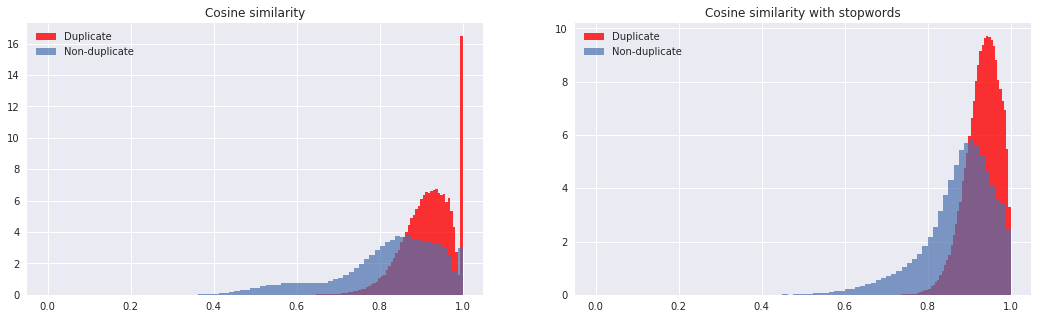

In [36]:
mask = Y_train['is_duplicate'] == 1

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("Cosine similarity")
plt.hist(X_train['wiki_cos'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['wiki_cos'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()

plt.subplot(1,2,2)
plt.title("Cosine similarity with stopwords")
plt.hist(X_train['wiki_stop_cos'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['wiki_stop_cos'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()
plt.show()

**Bray-Curtis distance**

In [44]:
%%time

X_train['wiki_braycurtis'] = [distance.braycurtis(trainDataVecs[i], trainDataVecs[i + n_train]) for i in range(n_train)] 
X_test['wiki_braycurtis'] = [distance.braycurtis(testDataVecs[i], testDataVecs[i + n_test]) for i in range(n_test)] 

X_train['wiki_braycurtis_stop'] = [distance.braycurtis(trainDataVecs_stop[i], trainDataVecs_stop[i + n_train]) for i in range(n_train)] 
X_test['wiki_braycurtis_stop'] = [distance.braycurtis(testDataVecs_stop[i], testDataVecs_stop[i + n_test]) for i in range(n_test)] 

CPU times: user 1min 57s, sys: 19.2 ms, total: 1min 57s
Wall time: 2min 13s


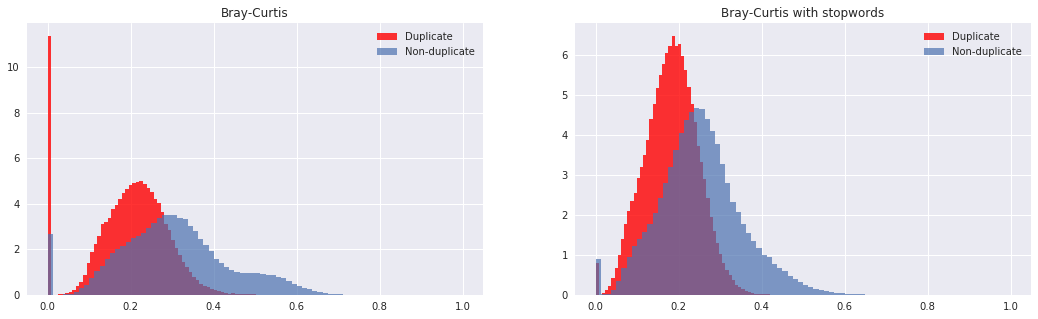

In [45]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("Bray-Curtis")
plt.hist(X_train['wiki_braycurtis'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['wiki_braycurtis'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()

plt.subplot(1,2,2)
plt.title("Bray-Curtis with stopwords")
plt.hist(X_train['wiki_braycurtis_stop'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['wiki_braycurtis_stop'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()
plt.show()

**Canberra distance**

In [46]:
%%time

X_train['wiki_canberra'] = [distance.canberra(trainDataVecs[i], trainDataVecs[i + n_train]) for i in range(n_train)] 
X_test['wiki_canberra'] = [distance.canberra(testDataVecs[i], testDataVecs[i + n_test]) for i in range(n_test)] 

X_train['wiki_canberra_stop'] = [distance.canberra(trainDataVecs_stop[i], trainDataVecs_stop[i + n_train]) for i in range(n_train)] 
X_test['wiki_canberra_stop'] = [distance.canberra(testDataVecs_stop[i], testDataVecs_stop[i + n_test]) for i in range(n_test)] 

CPU times: user 2min 21s, sys: 210 ms, total: 2min 21s
Wall time: 2min 24s


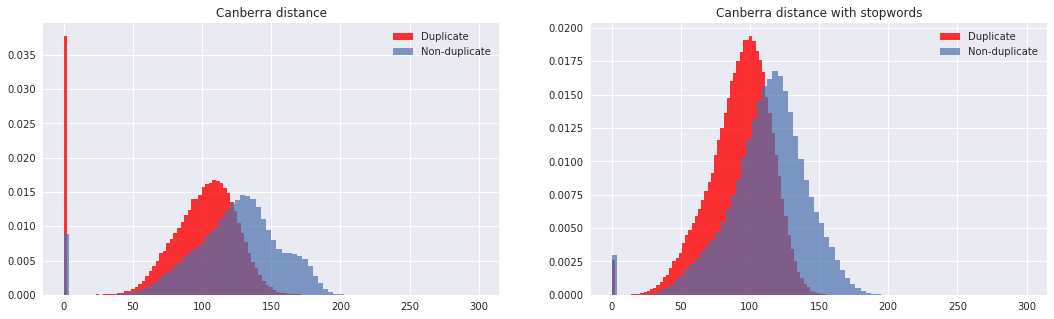

In [48]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("Canberra distance")
plt.hist(X_train['wiki_canberra'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['wiki_canberra'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()

plt.subplot(1,2,2)
plt.title("Canberra distance with stopwords")
plt.hist(X_train['wiki_canberra_stop'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['wiki_canberra_stop'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()
plt.show()

**Chebyshev distance**

In [49]:
%%time

X_train['wiki_chebyshev'] = [distance.chebyshev(trainDataVecs[i], trainDataVecs[i + n_train]) for i in range(n_train)] 
X_test['wiki_chebyshev'] = [distance.chebyshev(testDataVecs[i], testDataVecs[i + n_test]) for i in range(n_test)] 

X_train['wiki_chebyshev_stop'] = [distance.chebyshev(trainDataVecs_stop[i], trainDataVecs_stop[i + n_train]) for i in range(n_train)] 
X_test['wiki_chebyshev_stop'] = [distance.chebyshev(testDataVecs_stop[i], testDataVecs_stop[i + n_test]) for i in range(n_test)] 

CPU times: user 1min 53s, sys: 999 µs, total: 1min 53s
Wall time: 1min 54s


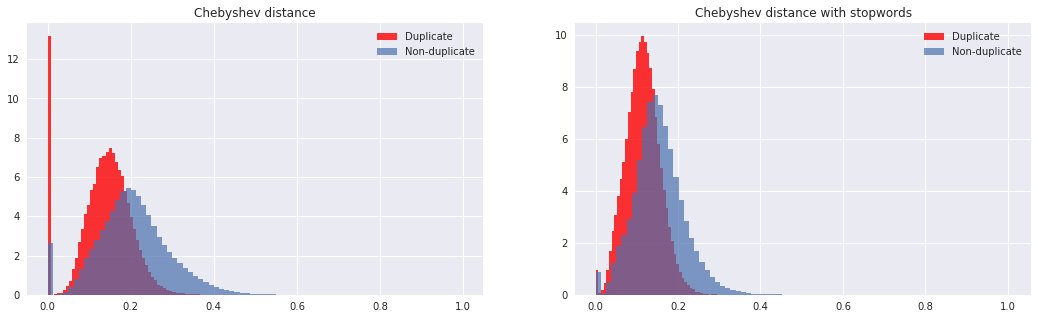

In [50]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("Chebyshev distance")
plt.hist(X_train['wiki_chebyshev'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['wiki_chebyshev'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()

plt.subplot(1,2,2)
plt.title("Chebyshev distance with stopwords")
plt.hist(X_train['wiki_chebyshev_stop'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['wiki_chebyshev_stop'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()
plt.show()

**Correlation**

In [51]:
%%time

X_train['wiki_correlation'] = [distance.correlation(trainDataVecs[i], trainDataVecs[i + n_train]) for i in range(n_train)] 
X_test['wiki_correlation'] = [distance.correlation(testDataVecs[i], testDataVecs[i + n_test]) for i in range(n_test)] 

X_train['wiki_correlation_stop'] = [distance.correlation(trainDataVecs_stop[i], trainDataVecs_stop[i + n_train]) for i in range(n_train)] 
X_test['wiki_correlation_stop'] = [distance.correlation(testDataVecs_stop[i], testDataVecs_stop[i + n_test]) for i in range(n_test)] 

CPU times: user 4min 30s, sys: 896 ms, total: 4min 31s
Wall time: 4min 37s


In [53]:
X_train['wiki_correlation'].fillna(0, inplace=True)
X_test['wiki_correlation'].fillna(0, inplace=True)
X_train['wiki_correlation_stop'].fillna(0, inplace=True)
X_test['wiki_correlation_stop'].fillna(0, inplace=True)

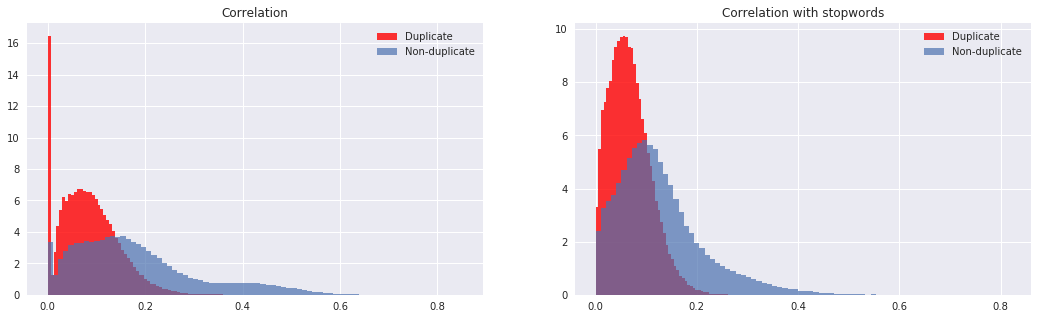

In [54]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("Correlation")
plt.hist(X_train['wiki_correlation'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['wiki_correlation'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()

plt.subplot(1,2,2)
plt.title("Correlation with stopwords")
plt.hist(X_train['wiki_correlation_stop'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['wiki_correlation_stop'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()
plt.show()

**Word Mover's Distance**

In [66]:
%time

X_train['wiki_wmd'] = [wmd(qtrain[0].loc[i], qtrain[0].loc[n_train + i], model_wiki) for i in range(n_train)]
X_train['wiki_wmd_stop'] = [wmd(qtrain[0].loc[i], qtrain[0].loc[n_train + i], model_wiki, False) for i in range(n_train)]

X_test['wiki_wmd'] = [wmd(qtest[0].loc[i], qtest[0].loc[n_test + i], model_wiki) for i in range(n_test)]
X_test['wiki_wmd_stop'] = [wmd(qtest[0].loc[i], qtest[0].loc[n_test + i], model_wiki, False) for i in range(n_test)]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


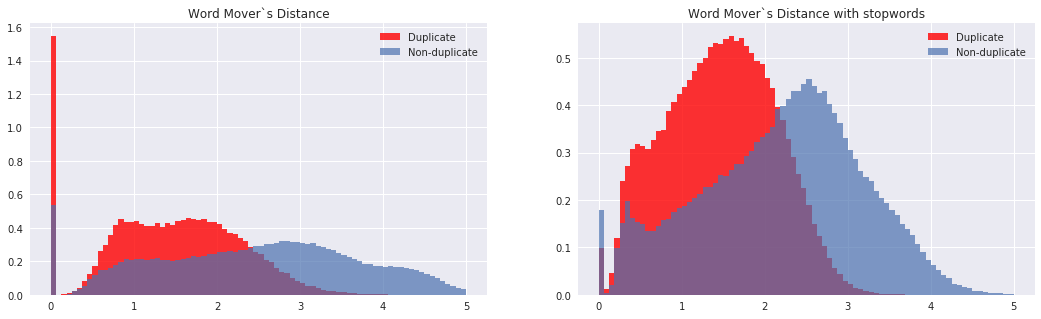

In [67]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("Word Mover`s Distance")
plt.hist(X_train['wiki_wmd'][mask], bins=80, range=[0,5], alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['wiki_wmd'][~mask], bins=80, alpha=0.7, range=[0,5], normed=True, label='Non-duplicate');
plt.legend()

plt.subplot(1,2,2)
plt.title("Word Mover`s Distance with stopwords")
plt.hist(X_train['wiki_wmd_stop'][mask], bins=80, alpha=0.8, range=[0,5], color='r', normed=True, label='Duplicate');
plt.hist(X_train['wiki_wmd_stop'][~mask], bins=80, alpha=0.7, range=[0,5], normed=True, label='Non-duplicate');
plt.legend()
plt.show()

In [72]:
features = ['wiki_cos', 'wiki_stop_cos', 'wiki_braycurtis', 'wiki_braycurtis_stop',
            'wiki_canberra', 'wiki_canberra_stop', 'wiki_chebyshev',
            'wiki_chebyshev_stop', 'wiki_correlation', 'wiki_correlation_stop',
            'wiki_wmd', 'wiki_wmd_stop']

X_train[features].to_csv('train_f3.csv')
X_test[features].to_csv('test_f3.csv')

## Doc2vec

In [82]:
# For building models
import gensim
from gensim import corpora, models
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence

In [97]:
class TaggedQuestions:
    def __init__(self, questions):
        self.questions = questions
    
    def __iter__(self):
        for i, question in enumerate(self.questions):
            tokens = question.split()
            yield LabeledSentence(words=tokens, tags=["Question %d" % i])

In [88]:
all_questions.reset_index(drop=True, inplace=True)

In [100]:
tagged_questions = TaggedQuestions(all_questions[0])

for q in tagged_questions:
    print(q)
    break

LabeledSentence(['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india', '?'], ['Question 0'])


**Parameters**

In [111]:
min_count = 20
window = 5
size = 200
negative = 5
workers = 8
alpha = 0.025
min_alpha = 0.025

In [112]:
# building model
model_dm = Doc2Vec(dm=1, min_count = min_count, window = window, size = size, negative = negative, 
                                     workers = workers, alpha = alpha, min_alpha = min_alpha)

model_dbow = Doc2Vec(dm=0, min_count = min_count, window = window, size = size, negative = negative, 
                                     workers = workers, alpha = alpha, min_alpha = min_alpha)

In [113]:
%%time

# building vocabulary
model_dm.build_vocab(tagged_questions)
model_dbow.build_vocab(tagged_questions)

CPU times: user 3min 34s, sys: 8.22 s, total: 3min 43s
Wall time: 3min 43s


In [114]:
model_dm.corpus_count

5500172

In [115]:
%%time

for epoch in range(10):
    model_dm.train(tagged_questions) 
    model_dm.alpha -= 0.002  # decrease the learning rate    
    model_dm.min_alpha = model_dm.alpha  # fix the learning rate, no decay
    print("DM epoch: %d" % epoch+1)
    
    model_dbow.train(tagged_questions) 
    model_dbow.alpha -= 0.002  # decrease the learning rate    
    model_dbow.min_alpha = model_dbow.alpha  # fix the learning rate, no decay
    print("DBOW epoch: %d" % epoch+1)

TypeError: Can't convert 'int' object to str implicitly

### Prediction

In [158]:
x_train = X_train
y_train = pd.DataFrame(Y_train)

In [199]:
import xgboost as xgb
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.33, random_state=2017)

params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["eta"] = 0.05
params["subsample"] = 0.7
params["min_child_weight"] = 5
params["colsample_bytree"] = 0.7
params["max_depth"] = 6
params["silent"] = 1
params["seed"] = 2107

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 500, watchlist, verbose_eval=50)

[0]	train-logloss:0.673807	valid-logloss:0.674002
[50]	train-logloss:0.430838	valid-logloss:0.434834
[100]	train-logloss:0.405027	valid-logloss:0.411063
[150]	train-logloss:0.392754	valid-logloss:0.401224
[200]	train-logloss:0.38367	valid-logloss:0.394895
[250]	train-logloss:0.376946	valid-logloss:0.390755
[300]	train-logloss:0.37121	valid-logloss:0.387609
[350]	train-logloss:0.366407	valid-logloss:0.385359
[400]	train-logloss:0.362421	valid-logloss:0.383598
[450]	train-logloss:0.359006	valid-logloss:0.382287


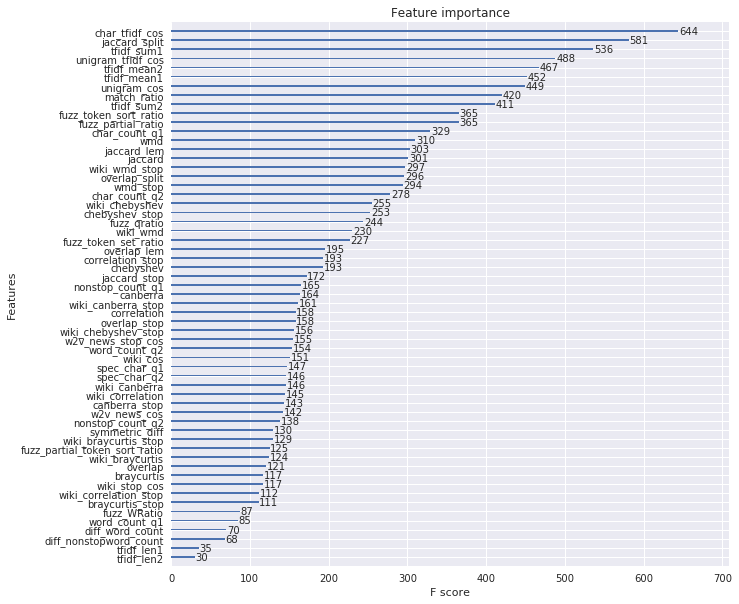

In [103]:
plt.rcParams['figure.figsize'] = (10, 10)
xgb.plot_importance(bst); plt.show()

In [200]:
log_loss(y_valid, [f(x) for x in bst.predict(d_valid)])

0.46049364298695528

In [202]:
log_loss(y_valid, bst.predict(d_valid))

0.381134393941233

## Prediction
### Model 1

In [187]:
%%time

params = {}
params["learning_rate"] = 0.05
params["subsample"] = 0.7
params["min_child_weight"] = 5
params["colsample_bytree"] = 0.7
params["max_depth"] = 6
params["silent"] = 1
params["seed"] = 2107

d_train = xgb.DMatrix(x_train, label=y_train)

clf_1 = xgb.XGBClassifier(**params, n_estimators=1000)
clf_1.fit(x_train, y_train)
p_test_1 = clf_1.predict_proba(X_test)[:,1]

CPU times: user 1h 10min 2s, sys: 8.64 s, total: 1h 10min 11s
Wall time: 11min 55s


In [194]:
p_test_1 = clf_1.predict_proba(X_test)[:,1]

### Model 2

In [160]:
%%time

params = {}
params["learning_rate"] = 0.02
params["subsample"] = 0.7
params["min_child_weight"] = 1
params["colsample_bytree"] = 0.7
params["max_depth"] = 6
params["silent"] = 1
params["seed"] = 2107

d_train = xgb.DMatrix(x_train, label=y_train)

clf_2 = xgb.XGBClassifier(**params, n_estimators=3000)
clf_2.fit(x_train, y_train)
p_test_2 = clf_2.predict_proba(X_test)[:,1]

CPU times: user 2h 31min 14s, sys: 20.3 s, total: 2h 31min 34s
Wall time: 22min 19s


In [195]:
p_test_2 = clf_2.predict_proba(X_test)[:,1]

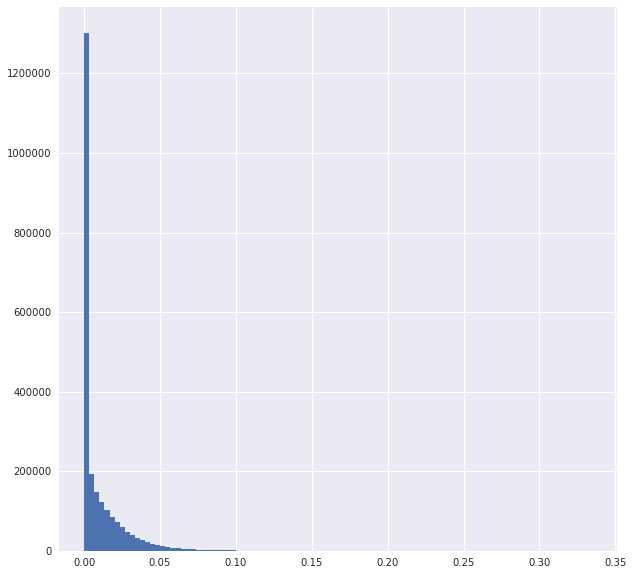

In [175]:
plt.hist(np.abs(p_test_2 - p_test_1),bins=100);

## Calibration

**scaling calibration: multiply by 0.165/mean(predicted probability)**

In [189]:
#a = 0.173 / 0.3692; b = (1 - 0.173) / (1 - 0.3692)
a = 0.165 / 0.37; b = (1 - 0.165) / (1 - 0.37)

In [190]:
def f(x):
    return a * x / (a * x + b * (1 - x))

In [196]:
p_test_12 = (p_test_1 + p_test_2) / 2

In [197]:
cp_test = [f(x) for x in p_test_12]
p_test_12 = cp_test

In [180]:
np.array(p_test) - np.array(p_test_12)

array([  2.27406217e-05,  -5.82490862e-03,  -5.20923385e-03, ...,
        -9.95084600e-08,  -4.10134049e-03,   4.45512784e-03])

In [119]:
np.array(p_test) < 0.01

array([ True, False, False, ...,  True, False, False], dtype=bool)

## Results

In [198]:
sub = pd.DataFrame()
sub['test_id'] = sample['test_id']
sub['is_duplicate'] = p_test_12
sub.to_csv('mix_xgb.csv', index=False)